<a href="https://colab.research.google.com/github/emreozeren/Uskudar_Unv_MakOgr/blob/main/244312503_Emre_Ozeren_Makine_Ogrenmesi_Vize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0 - Gerekli kütüphanelerin yüklenmesi

In [ ]:
!pip3 install -U ucimlrepo

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from itertools import cycle

#1 - Veri Setinin Yüklenmesi

In [ ]:
# Google Drive altında '244312503_Makine_Ogrenmesi_Vize' klasöründeki 'Dry_Bean_Dataset.xlsx' dosyanın veriseti olarak kullanılması.
drive.mount('/content/drive')

# Google Drive'dan veriyi yükleme
file_path = "/content/drive/MyDrive/244312503_Makine_Ogrenmesi_Vize/Dry_Bean_Dataset.xlsx"

df = pd.read_excel(file_path)
# Bağımlı değişken olan 'Class' sütununun ayrılması
X = df.drop('Class', axis=1)
y = df['Class']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# df verisetinin özniteliklerinin listelenmesi
print(df.dtypes)

Area                 int64
Perimeter          float64
MajorAxisLength    float64
MinorAxisLength    float64
AspectRation       float64
Eccentricity       float64
ConvexArea           int64
EquivDiameter      float64
Extent             float64
Solidity           float64
roundness          float64
Compactness        float64
ShapeFactor1       float64
ShapeFactor2       float64
ShapeFactor3       float64
ShapeFactor4       float64
Class               object
dtype: object


In [ ]:
# "Class" bağımsız değişkenimde kaç distinct kategori var?
print(y.nunique())

7


In [ ]:
# Ekran genişliğini artırmak için pandas ayarlarını değiştirme
pd.set_option('display.max_columns', None)  # Tüm kolonları göster
pd.set_option('display.width', 1000)  # Genişliği artır
pd.set_option('display.max_colwidth', None)

In [ ]:
# Orjinal veri setini bozmamak adına veri seti df_wf adında bir workfile dataframe'e kopyalanır
df_wf = df.copy()

#2 - Veri setinin rastgele 3 kolonuna %5 ve bir kolonuna %35 missing value eklenmesi

In [ ]:
# 'Area', 'ConvexArea', 'AspectRatio' kolonlarına 5% nan (missing data) veri ekleme

# İlgili kolonlardaki değişimin görülebilmesi için önceki ve sonraki değerleri gösterilir
print('Veriseti satır sayısı. :', len(df_wf))
print('Veriseti ''Area'' kolonu mevcut ''NaN'' satır sayısı. :',len(df_wf[df_wf['Area'].isna()]))
print('Veriseti ''ConvexArea'' kolonu mevcut ''NaN'' satır sayısı. :',len(df_wf[df_wf['ConvexArea'].isna()]))
print('Veriseti ''AspectRation'' kolonu mevcut ''NaN'' satır sayısı. :',len(df_wf[df_wf['AspectRation'].isna()]))

for col in ['Area', 'ConvexArea', 'AspectRation']:
  eksiksayi = int(0.05 * len(df_wf))
  eksik_indis = np.random.choice(df_wf.index, eksiksayi, replace=False)
  df_wf.loc[eksik_indis, col] = np.nan

print('----')
print('Veriseti ''Area'' kolonu yeni ''NaN'' satır sayısı. :', len(df_wf[df_wf['Area'].isna()]))
print('Veriseti ''ConvexArea'' kolonu yeni ''NaN'' satır sayısı. :', len(df_wf[df_wf['ConvexArea'].isna()]))
print('Veriseti ''AspectRation'' kolonu yeni ''NaN'' satır sayısı. :', len(df_wf[df_wf['AspectRation'].isna()]))

Veriseti satır sayısı. : 13611
Veriseti Area kolonu mevcut NaN satır sayısı. : 0
Veriseti ConvexArea kolonu mevcut NaN satır sayısı. : 0
Veriseti AspectRation kolonu mevcut NaN satır sayısı. : 0
----
Veriseti Area kolonu yeni NaN satır sayısı. : 680
Veriseti ConvexArea kolonu yeni NaN satır sayısı. : 680
Veriseti AspectRation kolonu yeni NaN satır sayısı. : 680


In [ ]:
# 'Extent' kolonuna %35 nan (missing data) veri ekleme
print('Veriseti ''Extent'' kolonu mevcut ''NaN'' satır sayısı. :', len(df_wf[df_wf['Extent'].isna()]))

for col in ['Extent']:
  eksiksayi = int(0.35 * len(df_wf))
  eksik_indis = np.random.choice(df_wf.index, eksiksayi, replace=False)
  df_wf.loc[eksik_indis, col] = np.nan

print('----')
print('Veriseti ''Extent'' kolonu yeni ''NaN'' satır sayısı. :', len(df_wf[df_wf['Extent'].isna()]))

Veriseti Extent kolonu mevcut NaN satır sayısı. : 0
----
Veriseti Extent kolonu yeni NaN satır sayısı. : 4763


In [ ]:
# 'Area' kolonundaki NaN değerleri ortanca değer ile doldurma
median_value = df_wf['Area'].median()
df_wf['Area'] = df_wf['Area'].fillna(median_value)
print('Area Median Value', median_value)

# 'ConvexArea' kolonundaki NaN değerleri ortanca değer ile doldurma
median_value = df_wf['ConvexArea'].median()
df_wf['ConvexArea'] = df_wf['ConvexArea'].fillna(median_value)
print('ConvexArea Median Value', median_value)

# 'AspectRation' kolonundaki NaN değerleri ortalama ile doldurma
mean_value = df_wf['AspectRation'].median()
df_wf['AspectRation'] = df_wf['AspectRation'].fillna(mean_value)
print('AspectRation Median Value', mean_value)

# Değişikliklerden sonra NaN değer kontrolü
print('----')
print('Veriseti ''Area'' kolonu NaN doldurma işlemi sonrası NaN satır sayısı :', len(df_wf[df_wf['Area'].isna()]))
print('Veriseti ''ConvexArea'' kolonu NaN doldurma işlemi sonrası NaN satır sayısı :', len(df_wf[df_wf['ConvexArea'].isna()]))
print('Veriseti ''AspectRation'' kolonu NaN doldurma işlemi sonrası NaN satır sayısı :', len(df_wf[df_wf['AspectRation'].isna()]))
print('----')

Area Median Value 44642.0
ConvexArea Median Value 45229.0
AspectRation Median Value 1.5503478069404018
----
Veriseti Area kolonu NaN doldurma işlemi sonrası NaN satır sayısı : 0
Veriseti ConvexArea kolonu NaN doldurma işlemi sonrası NaN satır sayısı : 0
Veriseti AspectRation kolonu NaN doldurma işlemi sonrası NaN satır sayısı : 0
----


%35 oranında eksik veri barındıran 'Extent' kolonu için satır mı yoksa sütun mü silmenin daha doğru olacağı kararı için öncelikle bir feature importance ile özniteliklerin önem durumlarına bakmanın anlamlı olacağını düşündüm.

In [ ]:
X = df_wf.drop('Class', axis=1)
y = df_wf['Class']

# RandomForestClassifier modelini oluşturma ve eğitme
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Özellik önem derecelerini bulma ve sonucu bir Pandas dataframe'e dönüştürme
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Sonuçları yazdırma
feature_importance_df


,Feature,Importance
12,ShapeFactor1,0.103081
1,Perimeter,0.099243
3,MinorAxisLength,0.096833
11,Compactness,0.095284
7,EquivDiameter,0.087749
2,MajorAxisLength,0.087393
14,ShapeFactor3,0.085005
5,Eccentricity,0.083486
10,roundness,0.057487
13,ShapeFactor2,0.046730


%35 verisi eksik olan "Extent" özniteliği önem derecesi açısından diğer özniteliklere göre daha aşağıda olduğundan; bu özniteliği kaldırmanın büyük bir kayıp olmayacağı sonucuna varabiliriz.

In [ ]:
# 'Extent' özniteliğini verisetinden kaldırma
df_wf = df_wf.drop('Extent', axis=1)

#3 - Aykırı Değer Tespiti (Outlier Detection)

Tüm öznitelikler için aykırı değer tespiti yapılır...

In [ ]:
# IQR yöntemi ile aykırı değer tespiti
def aykiri_degerleri_tespit(veri):
    Q1 = veri.quantile(0.25)
    Q3 = veri.quantile(0.75)
    IQR = Q3 - Q1
    alt_sinir = Q1 - 1.5 * IQR
    ust_sinir = Q3 + 1.5 * IQR
    aykiri_deger = veri[(veri < alt_sinir) | (veri > ust_sinir)]
    return aykiri_deger

# Her sütun için aykırı değerleri tespit etme ve yazdırma
for col in df_wf.select_dtypes(include=np.number).columns:  # Sayısal sütunları seçme
    aykiri_deger = aykiri_degerleri_tespit(df_wf[col])
    print(f"{col} sütunundaki aykırı değerler:\n{aykiri_deger}\n")

Area sütunundaki aykırı değerler:
3335     95349.0
3336     95737.0
3337     95824.0
3339     96319.0
3340     97054.0
          ...   
5496    106806.0
5497    107911.0
5498    114858.0
5499    115608.0
5500    116272.0
Name: Area, Length: 558, dtype: float64

Perimeter sütunundaki aykırı değerler:
3364    1391.532
3368    1432.713
3369    1427.056
3371    1417.944
3372    1389.634
          ...   
3866    1921.685
3867    1895.940
3868    1884.557
3869    1919.868
3870    1985.370
Name: Perimeter, Length: 500, dtype: float64

MajorAxisLength sütunundaki aykırı değerler:
3426    581.235920
3427    564.968608
3429    563.717847
3431    562.823437
3434    582.438203
           ...    
3866    738.144502
3867    726.373493
3868    715.053040
3869    719.125690
3870    738.860153
Name: MajorAxisLength, Length: 379, dtype: float64

MinorAxisLength sütunundaki aykırı değerler:
3088    285.347398
3142    289.499746
3144    280.253937
3171    285.445525
3187    280.276974
           ...    
5

In [ ]:
# Aykırı değerleri sınır değerlerle değiştirme
def aykiri_deger_degistirme(veri):
    Q1 = veri.quantile(0.25)
    Q3 = veri.quantile(0.75)
    IQR = Q3 - Q1
    alt_sinir = Q1 - 1.5 * IQR
    ust_sinir = Q3 + 1.5 * IQR
    veri = veri.clip(lower = alt_sinir, upper = ust_sinir)
    return veri

# Aykırı değerleri sınırlarla değiştirme işlemi
for col in df_wf.select_dtypes(include=np.number).columns:
    df_wf[col] = aykiri_deger_degistirme(df_wf[col])

# Değişikliklerden sonra aykırı değer kontrolü
for col in df_wf.select_dtypes(include=np.number).columns:
    aykiri_deger = aykiri_degerleri_tespit(df_wf[col])
    print(f"{col} sütunundaki aykırı değerler:\n{aykiri_deger}\n")

Area sütunundaki aykırı değerler:
Series([], Name: Area, dtype: float64)

Perimeter sütunundaki aykırı değerler:
Series([], Name: Perimeter, dtype: float64)

MajorAxisLength sütunundaki aykırı değerler:
Series([], Name: MajorAxisLength, dtype: float64)

MinorAxisLength sütunundaki aykırı değerler:
Series([], Name: MinorAxisLength, dtype: float64)

AspectRation sütunundaki aykırı değerler:
Series([], Name: AspectRation, dtype: float64)

Eccentricity sütunundaki aykırı değerler:
Series([], Name: Eccentricity, dtype: float64)

ConvexArea sütunundaki aykırı değerler:
Series([], Name: ConvexArea, dtype: float64)

EquivDiameter sütunundaki aykırı değerler:
Series([], Name: EquivDiameter, dtype: float64)

Solidity sütunundaki aykırı değerler:
Series([], Name: Solidity, dtype: float64)

roundness sütunundaki aykırı değerler:
Series([], Name: roundness, dtype: float64)

Compactness sütunundaki aykırı değerler:
Series([], Name: Compactness, dtype: float64)

ShapeFactor1 sütunundaki aykırı değerl

#4 - Özellik Ölçekleme (Feature Scaling)

Hem standard hem de min-max scaler ölçekleme ile her kolonu ölçeklediğimizde sonucun nasıl olacağını gözle kontrol etmek ve bu ölçekleme farkı ile ilgili fikir sahibi olabilmek için önce tüm kolonlar hem standardscaler hem de min-max scaler ölçeklemesine tabi tutulur.

In [ ]:
# Ölçekleme öncesi veri kıyaslama için yazdırılır
print(df_wf.head())

# Sayısal öznitelikler seçilir
sayisal_oznitelikler = df_wf.select_dtypes(include=np.number).columns

# StandardScaler kullanarak ölçekleme
df_wf_standard = df_wf.copy()
scaler = StandardScaler()
df_wf_standard[sayisal_oznitelikler] = scaler.fit_transform(df_wf_standard[sayisal_oznitelikler])

# MinMaxScaler kullanarak ölçekleme (alternatif)
df_wf_minmax = df_wf.copy()
scaler = MinMaxScaler()
df_wf_minmax[sayisal_oznitelikler] = scaler.fit_transform(df_wf_minmax[sayisal_oznitelikler])


# Ölçeklenmiş verileri kontrol etmek için:
print('---------')
print('--- Standard ---')
print(df_wf_standard.head())
print('---------')
print('--- Min-Max ---')
print(df_wf_minmax.head())


      Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  Eccentricity  ConvexArea  EquivDiameter  Solidity  roundness  Compactness  ShapeFactor1  ShapeFactor2  ShapeFactor3  ShapeFactor4  Class
0  28395.0    610.291       208.178117       173.888747      1.197191       0.57412     28715.0     190.141097  0.988856   0.958027     0.913358      0.007332      0.003147      0.834222      0.998724  SEKER
1  28734.0    638.018       200.524796       182.734419      1.097356       0.57412     29172.0     191.272750  0.984986   0.887034     0.941972      0.006979      0.003564      0.867978      0.998430  SEKER
2  29380.0    624.110       212.826130       175.931143      1.209713       0.57412     29690.0     193.410904  0.989559   0.947849     0.908774      0.007244      0.003048      0.825871      0.999066  SEKER
3  30008.0    645.884       210.557999       182.516516      1.153638       0.57412     30724.0     195.467062  0.979156   0.903936     0.928329      0.007017      0.00

Veride ölçekleme yapılmadan önce de görülebileceği gibi bir özniteliğin değerleri ('Area' özniteliği) 30000 gibi değerler içeriyorken, bir başka öznitelik ('AspectRation' özniteliği) 1 civarında değerler içermektedir.

Bu durumda, büyük değerlere sahip özellikler modelde daha önemli/etkili olurken, küçük değerlere sahip özellikler göz ardı edilebilir.

Ayrıca yaptığım hızlı araştırmalarda; "eğer veri çok büyük farklarla ölçeklenmişse, MinMaxScaler kullanmak faydalı olabilir. Eğer verinin dağılımı normal ise ve modelinizin varsayımları buna uygunsa, StandardScaler tercih edilebilir." gibi sonuçlar bulunduğundan öznitelikler detaylı incelenerek hangi tür ölçekleme yapılması gerektiğinin tek tek analiz edilmesi daha doğru olacaktır.

Veri setindeki tüm kolonların yatıklık (skewness) değerlerini hesap edip buna göre her kolon için uygun ölçekleme tipi belirlemek daha doğru bir yaklaşım olacaktır. Ayrıca tüm kolonlar için BloxPlot grafikleri çizilir.

**Skewness** < 0.5: Bu durumda, dağılım az çarpık veya simetrik kabul edilir. Verinin büyük bir kısmı merkez etrafında yoğunlaşmıştır ve dağılım normal dağılıma yakın olabilir. Bu durumda, StandardScaler (z-score normalization) kullanılması daha uygundur, çünkü verinin ortalama 0 ve standart sapma 1 olmasını sağlamak, normal dağılıma daha yakın bir hale getirebilir.

**Skewness** > 0.5: Bu durumda, dağılım belirgin şekilde sağa ya da sola çarpık olur. Çarpıklığı gidermek için MinMaxScaler kullanılır. MinMaxScaler, veriyi belirli bir 0 ile 1 aralığına çekerek, verinin uç noktalarındaki etkilerin sınırlanmasına yardımcı olur. Bu, çarpıklığın etkilerini azaltarak, modelin daha sağlıklı eğitim yapmasına olanak sağlar.

Area sütununun yatıklık (skewness): 0.9345880248878016
Area için MinMaxScaler kullanılacak.
count    13611.000000
mean         0.394864
std          0.241881
min          0.000000
25%          0.220583
50%          0.326098
75%          0.532350
max          1.000000
Name: Area, dtype: float64


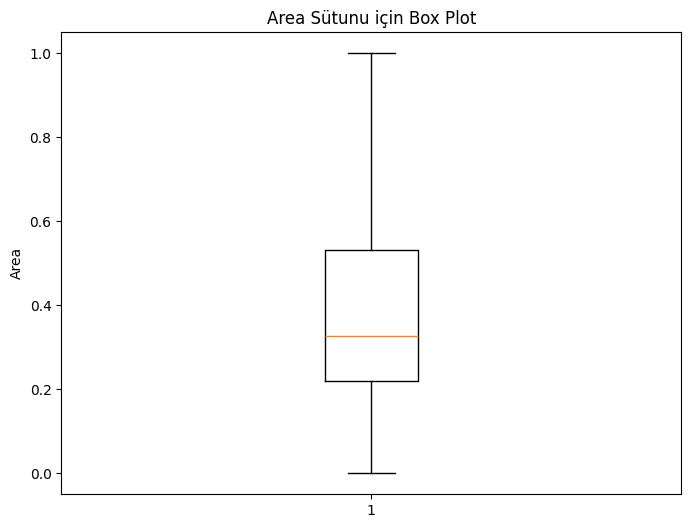

Perimeter sütununun yatıklık (skewness): 0.9615620879151572
Perimeter için MinMaxScaler kullanılacak.
count    13611.000000
mean         0.374167
std          0.218982
min          0.000000
25%          0.207167
50%          0.313096
75%          0.524300
max          1.000000
Name: Perimeter, dtype: float64


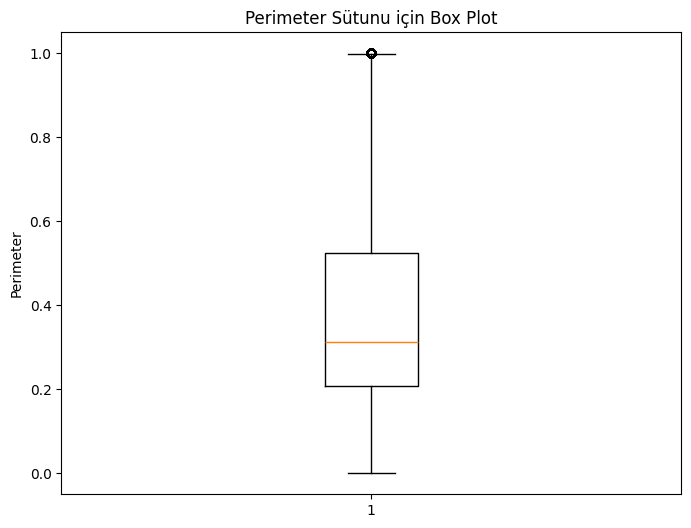

MajorAxisLength sütununun yatıklık (skewness): 0.9708966958742523
MajorAxisLength için MinMaxScaler kullanılacak.
count    13611.000000
mean         0.357366
std          0.212700
min          0.000000
25%          0.184554
50%          0.299942
75%          0.510732
max          1.000000
Name: MajorAxisLength, dtype: float64


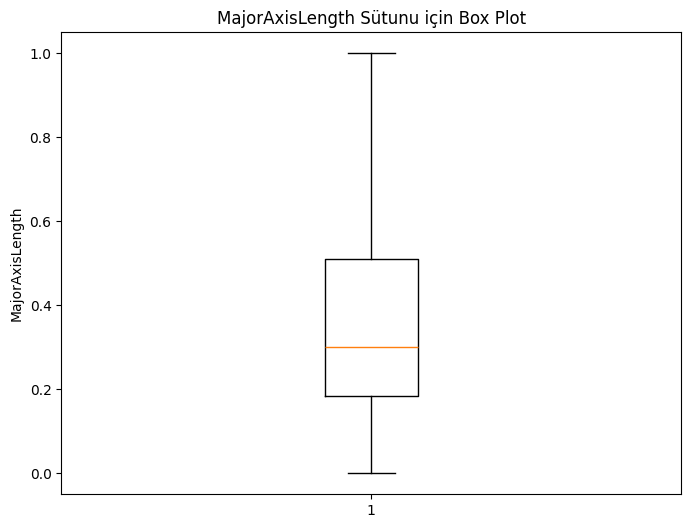

MinorAxisLength sütununun yatıklık (skewness): 0.7277300500857654
MinorAxisLength için MinMaxScaler kullanılacak.
count    13611.000000
mean         0.486670
std          0.209455
min          0.000000
25%          0.341250
50%          0.447355
75%          0.604750
max          1.000000
Name: MinorAxisLength, dtype: float64


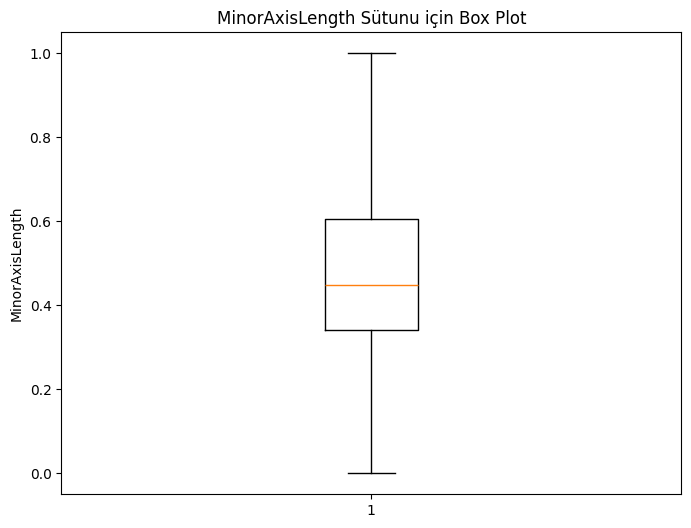

AspectRation sütununun yatıklık (skewness): 0.44290757632519956
AspectRation için StandardScaler kullanılacak.
count    1.361100e+04
mean    -1.670514e-16
std      1.000037e+00
min     -2.254604e+00
25%     -5.952367e-01
50%     -1.161787e-01
75%      5.110081e-01
max      2.170375e+00
Name: AspectRation, dtype: float64


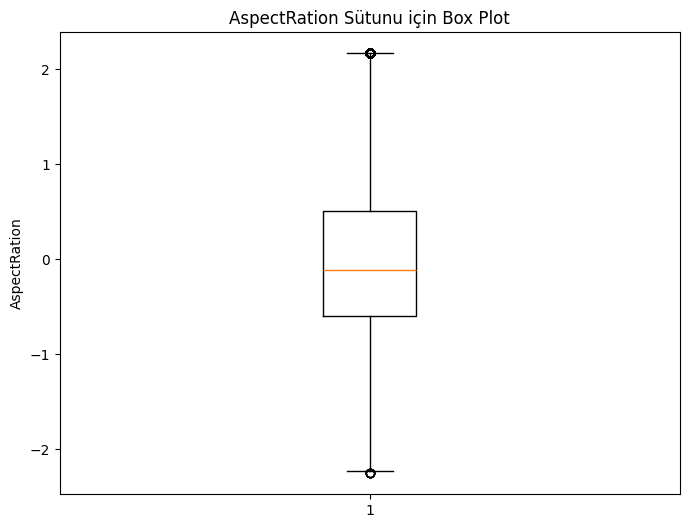

Eccentricity sütununun yatıklık (skewness): -0.6100580191544878
Eccentricity için MinMaxScaler kullanılacak.
count    13611.000000
mean         0.534043
std          0.246708
min          0.000000
25%          0.420416
50%          0.564242
75%          0.700693
max          1.000000
Name: Eccentricity, dtype: float64


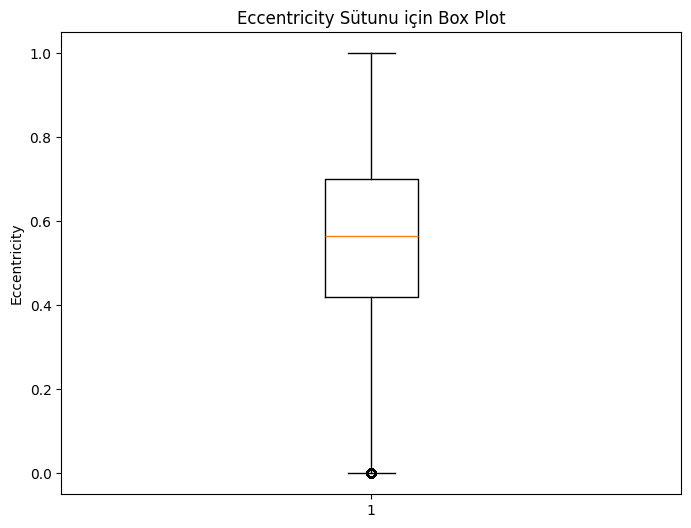

ConvexArea sütununun yatıklık (skewness): 0.9391870449277774
ConvexArea için MinMaxScaler kullanılacak.
count    13611.000000
mean         0.393442
std          0.241628
min          0.000000
25%          0.219404
50%          0.324404
75%          0.531642
max          1.000000
Name: ConvexArea, dtype: float64


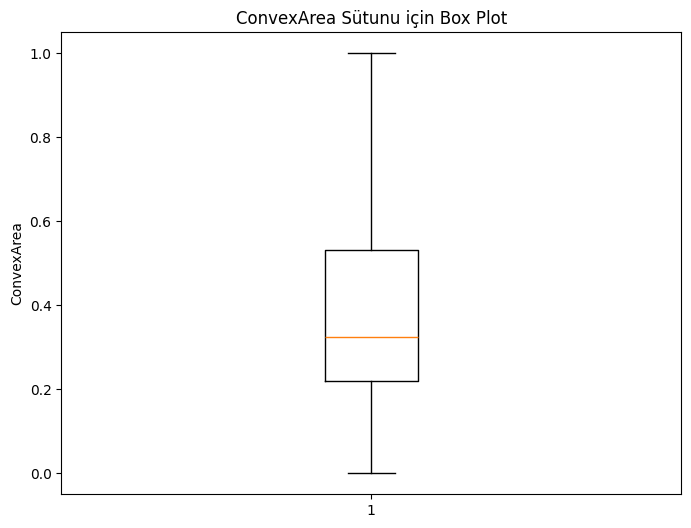

EquivDiameter sütununun yatıklık (skewness): 0.8328950071540318
EquivDiameter için MinMaxScaler kullanılacak.
count    13611.000000
mean         0.410924
std          0.220533
min          0.000000
25%          0.250613
50%          0.359427
75%          0.550368
max          1.000000
Name: EquivDiameter, dtype: float64


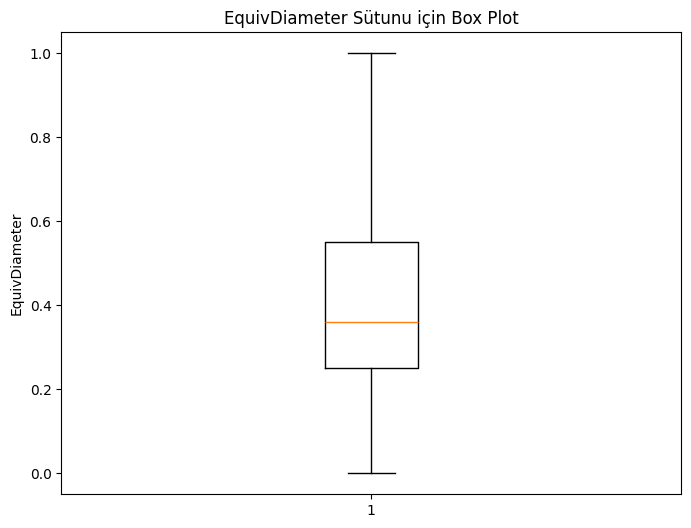

Solidity sütununun yatıklık (skewness): -0.8446106725326868
Solidity için MinMaxScaler kullanılacak.
count    13611.000000
mean         0.534649
std          0.230324
min          0.000000
25%          0.419689
50%          0.588014
75%          0.699482
max          1.000000
Name: Solidity, dtype: float64


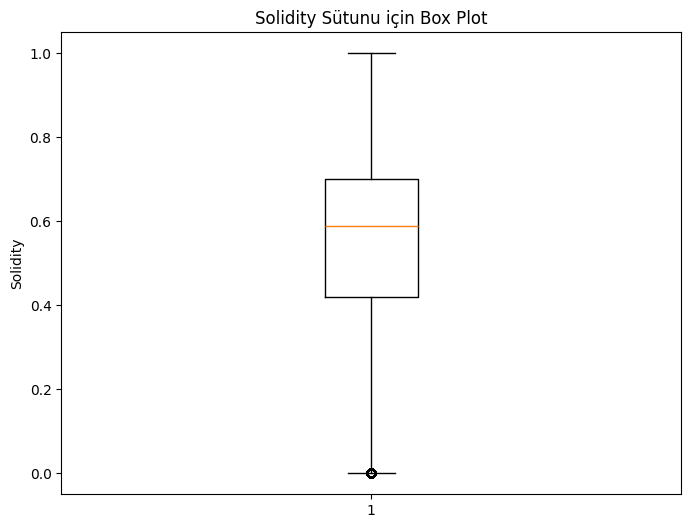

roundness sütununun yatıklık (skewness): -0.4921541819351273
roundness için StandardScaler kullanılacak.
count    1.361100e+04
mean     3.006925e-16
std      1.000037e+00
min     -2.882317e+00
25%     -7.088661e-01
50%      1.638893e-01
75%      7.401012e-01
max      2.001805e+00
Name: roundness, dtype: float64


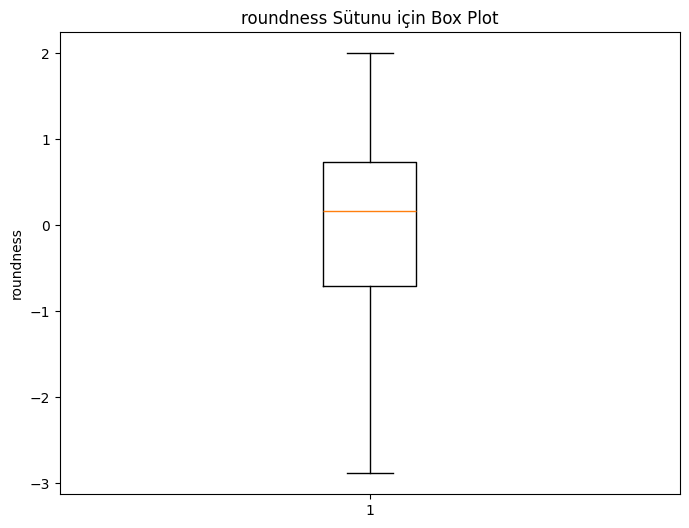

Compactness sütununun yatıklık (skewness): 0.01879217777861925
Compactness için StandardScaler kullanılacak.
count    1.361100e+04
mean    -5.011542e-17
std      1.000037e+00
min     -2.358025e+00
25%     -6.068330e-01
50%      2.417019e-02
75%      5.606283e-01
max      2.311820e+00
Name: Compactness, dtype: float64


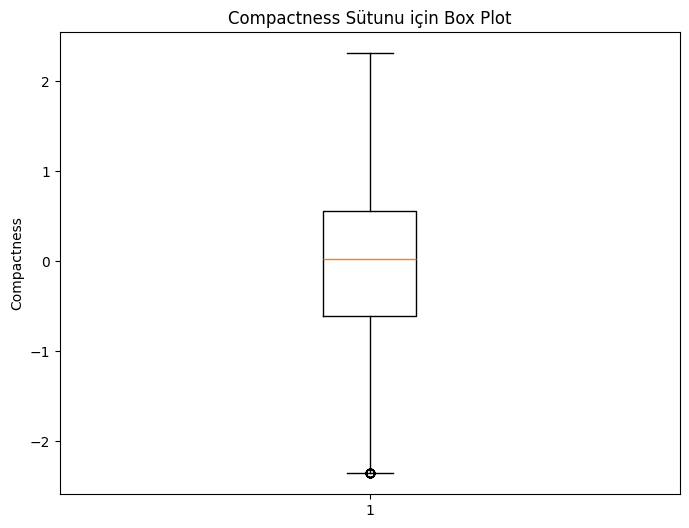

ShapeFactor1 sütununun yatıklık (skewness): -0.3291502321592489
ShapeFactor1 için StandardScaler kullanılacak.
count    1.361100e+04
mean     8.686673e-16
std      1.000037e+00
min     -2.520980e+00
25%     -6.253443e-01
50%      6.136505e-02
75%      6.384126e-01
max      2.534048e+00
Name: ShapeFactor1, dtype: float64


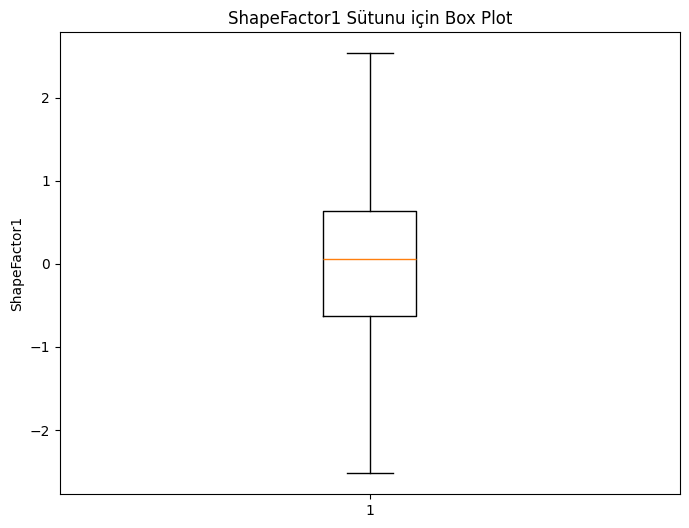

ShapeFactor2 sütununun yatıklık (skewness): 0.30119273205169816
ShapeFactor2 için StandardScaler kullanılacak.
count    1.361100e+04
mean     1.336411e-16
std      1.000037e+00
min     -1.932991e+00
25%     -9.439025e-01
50%     -3.762062e-02
75%      7.624716e-01
max      3.270983e+00
Name: ShapeFactor2, dtype: float64


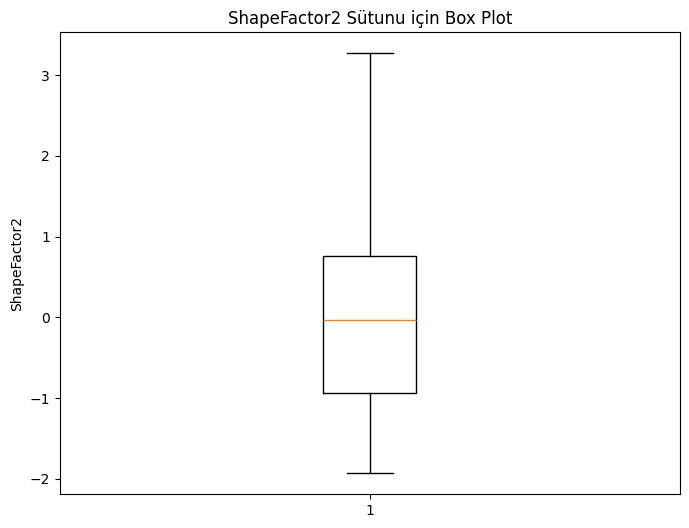

ShapeFactor3 sütununun yatıklık (skewness): 0.1930511910089271
ShapeFactor3 için StandardScaler kullanılacak.
count    1.361100e+04
mean    -5.011542e-16
std      1.000037e+00
min     -2.373260e+00
25%     -6.306426e-01
50%     -1.228201e-02
75%      5.375663e-01
max      2.289880e+00
Name: ShapeFactor3, dtype: float64


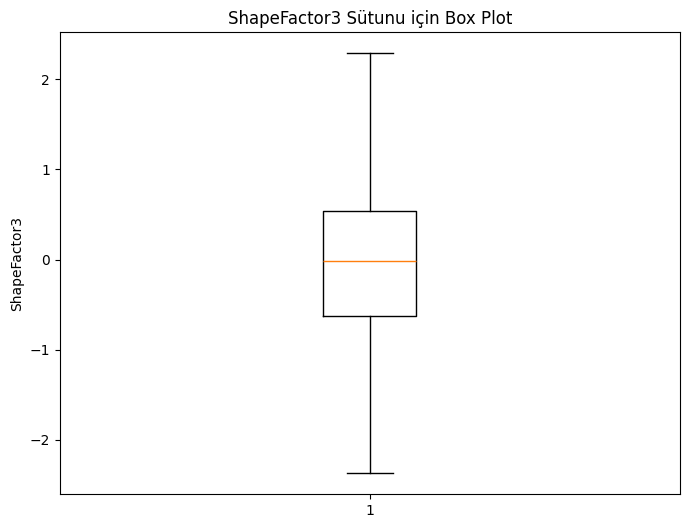

ShapeFactor4 sütununun yatıklık (skewness): -1.040056891463926
ShapeFactor4 için MinMaxScaler kullanılacak.
count    13611.000000
mean         0.644439
std          0.267895
min          0.000000
25%          0.509750
50%          0.727900
75%          0.849584
max          1.000000
Name: ShapeFactor4, dtype: float64


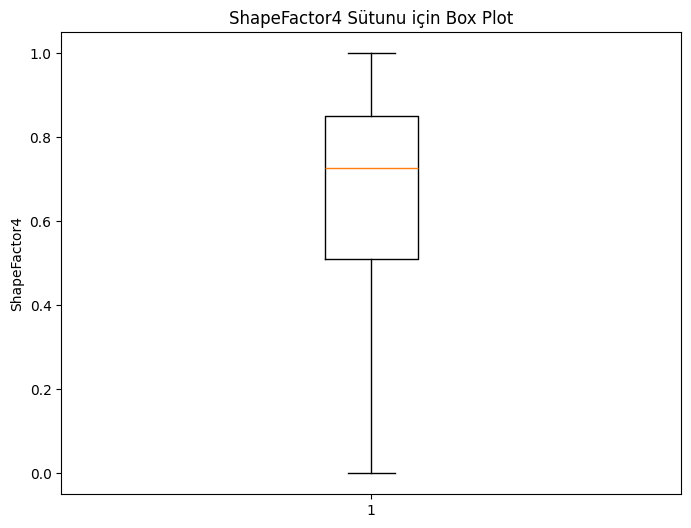

In [ ]:
# Skewness değerlerini hesaplama ve ölçekleme tipini belirleme
for col in df_wf.select_dtypes(include=np.number).columns:
    skewness = skew(df_wf[col])
    print(f"{col} sütununun yatıklık (skewness): {skewness}")
    if abs(skewness) < 0.5:
        print(f"{col} için StandardScaler kullanılacak.")
        scaler = StandardScaler()
        df_wf[col] = scaler.fit_transform(df_wf[[col]])
    else:
        print(f"{col} için MinMaxScaler kullanılacak.")
        scaler = MinMaxScaler()
        df_wf[col] = scaler.fit_transform(df_wf[[col]])
    print(df_wf[col].describe())
    plt.figure(figsize=(8, 6))
    plt.boxplot(df_wf[col])
    plt.title(f'{col} Sütunu için Box Plot')
    plt.ylabel(col)
    plt.show()


#5 - Kategorik Verilerin Kodlanması

Kategorik Verilerin Kodlanması: LabelEncoder kullanarak sınıf etiketlerini numerik hale getirin. Eğer başka kategorik sütunlar varsa, OneHotEncoder veya pd.get_dummies() ile dönüştürün.


In [ ]:
# 'Class' hedef değişkeni için Etiket Kodlaması
le = LabelEncoder()
df_wf['Class'] = le.fit_transform(df_wf['Class'])

# Başka kategorik sütunlar olup olmadığının kontrolü
kategori_kolon = df_wf.select_dtypes(include=['object']).columns

if len(kategori_kolon) > 0:
    df_wf = pd.get_dummies(df_wf, columns=kategori_kolon, drop_first=True)
else:
    print("Class özniteliği dışında kategorik bir öznitelik bulunmuyor.")

print('---------')
print('Class özniteliğindeki farklı değerler : ',df_wf['Class'].unique())


Class özniteliği dışında kategorik bir öznitelik bulunmuyor.
---------
Class özniteliğindeki farklı değerler :  [5 0 1 2 4 6 3]


#6 - PCA (Principal Component Analysis)

İstenen : PCA (Principal Component Analysis): PCA uygulayarak boyut indirgeme gerçekleştirin. (Number of componenti (seçilecek özvektör sayısını) percentage of explained variences in ortalamasından büyük olan değerler için seçin. )) Açıklanan varyans oranlarını inceleyin ve en iyi iki öznitelik için discrimination powerı 2 boyutlu grafikle gösterin.

Açıklanan Varyans Oranları: [7.18267148e-01 2.11846738e-01 4.58910498e-02 1.01050530e-02
 7.89087086e-03 1.98617939e-03 1.68506665e-03 1.06776607e-03
 4.73447339e-04 4.63160947e-04 2.15931984e-04 7.94580668e-05
 1.66590401e-05 7.69547780e-06 3.77572353e-06]
Açıklanan Varyans Ortalaması: 0.06666666666666667
Ortalamadan büyük varyansa sahip bileşen sayısı: 2


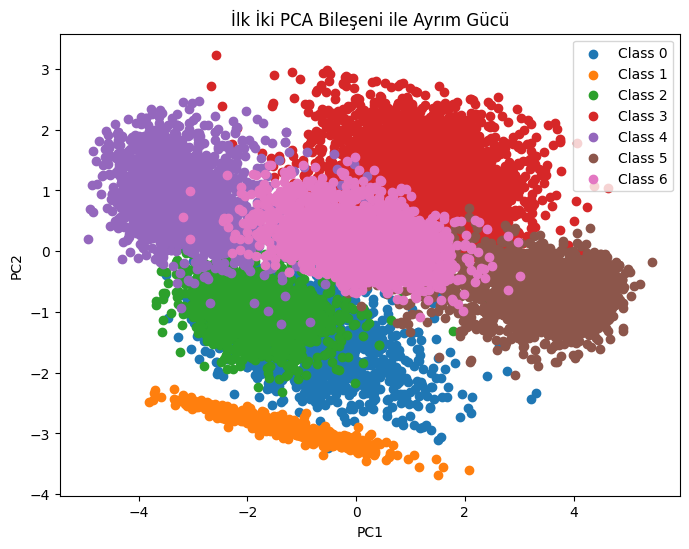

PCA Bileşenlerinin Özniteliklerden Oluşumu:
PC1: [-0.06431518 -0.06498748 -0.07359725 -0.02296819 -0.43718089 -0.10864806
 -0.06422502 -0.05997942  0.04611529  0.40444842  0.44782323  0.09922361
  0.43942305  0.44744769  0.07512658]
PC2: [-0.15727836 -0.13914981 -0.11037374 -0.17202166  0.20437621  0.04705755
 -0.1567039  -0.14912689  0.0276058   0.07680877 -0.19515921  0.82936733
  0.22792893 -0.19271549  0.0407214 ]


In [ ]:
# PCA uygulaması
X_pca = df_wf.drop('Class', axis=1)
y_pca = df_wf['Class']

pca = PCA()
X_pca_transformed = pca.fit_transform(X_pca)

explained_variance_ratio = pca.explained_variance_ratio_
print("Açıklanan Varyans Oranları:", explained_variance_ratio)

# Açıklanan varyansın ortalamasını hesapla
average_variance = np.mean(explained_variance_ratio)
print("Açıklanan Varyans Ortalaması:", average_variance)


# Ortalamadan büyük varyansa sahip bileşen sayısını bul
n_components = np.sum(explained_variance_ratio > average_variance)
print("Ortalamadan büyük varyansa sahip bileşen sayısı:", n_components)


# PCA'yı seçilen bileşen sayısı ile tekrar uygula
pca = PCA(n_components=n_components)
X_pca_transformed = pca.fit_transform(X_pca)

# Dönüştürülmüş veriyi yeni bir DataFrame'e kaydet
df_pca = pd.DataFrame(data = X_pca_transformed, columns = [f'PC{i+1}' for i in range(n_components)])
df_pca['Class'] = y_pca

# İlk iki bileşeni kullanarak ayrım gücünü göster
plt.figure(figsize=(8, 6))
for class_label in np.unique(y_pca):
    plt.scatter(X_pca_transformed[y_pca == class_label, 0], X_pca_transformed[y_pca == class_label, 1], label=f'Class {class_label}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('İlk İki PCA Bileşeni ile Ayrım Gücü')
plt.legend()
plt.show()

# Hangi PCA bileşenlerinin hangi özniteliklerden seçildiğini göster
print("PCA Bileşenlerinin Özniteliklerden Oluşumu:")
for i, component in enumerate(pca.components_):
    print(f"PC{i+1}: {component}")


Bazı sınıflar oldukça net bir şekilde ayrışmış görünüyor. Özellikle Class 0, Class 1, Class 3 ve Class 5 kendi kümelerini belirgin biçimde oluşturmuş. Bu sınıflar arasında çok fazla örtüşme görünmüyor.

Class 4 ve Class 6 biraz daha karmaşık bir bölgede duruyor. Özellikle merkez bölgede Class 4 (fuşya renkli) ile Class 6 (gri renkli) arasında belirli bir örtüşme gözleniyor. Bu durum, bu iki sınıfın orijinal veri uzayında da birbiriyle daha yakın özelliklere sahip olabileceğini gösteriyor.

Bazı sınıflar (örneğin Class 2 ve Class 1), daha geniş bir alana dağılmış. Bazıları (örneğin Class 5) daha kompakt ve yoğun bir dağılıma sahip.

#7 - LDA (Linear Discriminant Analysis)

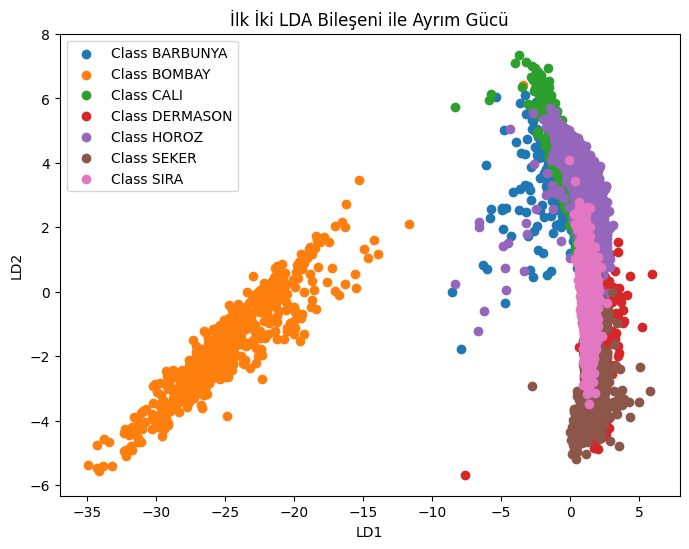

LDA Bileşenlerinin Özniteliklerden Oluşumu:


array([[ 7.58603039e-01, -1.70021092e+01, -1.13840882e+02,
         9.14219277e+01, -4.55467377e-01,  1.08896056e+01,
         9.21147874e-01,  8.35558347e+01, -3.93313033e+00,
        -7.15180142e+00,  5.53105618e+00,  7.83844480e+00,
         8.97484553e-01, -9.78621246e+00,  9.58781579e+00],
       [-1.46034564e+01,  1.60314513e+03,  1.80568019e+03,
         1.93312185e+01,  7.36807165e-02,  6.56271453e+01,
        -4.10453217e+01, -2.50808543e+03, -1.67970684e+01,
         6.45481663e+01,  4.05471113e+02,  4.44989853e+01,
        -9.36278176e+01, -2.00773053e+02, -5.43877886e+00],
       [ 2.38470737e+00, -2.01130121e+02, -5.98855965e+01,
        -4.57722947e+01, -2.79314940e-01,  1.42294941e+01,
         1.98889103e+00,  3.64079749e+02, -1.73212109e+00,
        -5.90035817e+00,  8.26926626e+00,  4.65391148e+00,
         1.27825814e+01, -1.32173809e+01, -7.32684129e+00],
       [ 2.16592189e+00, -3.55665476e+00, -6.85733986e+01,
         2.72503513e+00, -6.85486289e-01,  1.02379211

In [ ]:
X_lda = df_wf.drop('Class', axis=1)
y_lda = df_wf['Class']

# LDA uygulaması
lda = LDA(n_components=3)  # n_components'i 3 olarak ayarladık
X_lda_transformed = lda.fit_transform(X_lda, y_lda)

# Dönüştürülmüş veriyi yeni bir DataFrame'e kaydet
df_lda = pd.DataFrame(data=X_lda_transformed, columns=[f'LD{i+1}' for i in range(3)])
df_lda['Class'] = y_lda

# İlk iki LDA bileşenini kullanarak ayrım gücünü göster
plt.figure(figsize=(8, 6))
for class_label in np.unique(y):
    plt.scatter(X_lda_transformed[y == class_label, 0], X_lda_transformed[y == class_label, 1], label=f'Class {class_label}')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('İlk İki LDA Bileşeni ile Ayrım Gücü')
plt.legend()
plt.show()

# Hangi LDA bileşenlerinin hangi özniteliklerden seçildiğini göster
print("LDA Bileşenlerinin Özniteliklerden Oluşumu:")
lda.coef_



LDA Bileşeni 1 ekseninde sınıflar çok net bir şekilde ayrışmış durumda.

Class 1 (mor renk) özellikle çok belirgin bir şekilde -30 civarına konumlanmış ve diğer sınıflardan tamamen ayrılmış. Class 0, Class 5, Class 3, Class 4, Class 2, Class 6 sıralı şekilde pozitif eksende dizilmişler.

LDA Bileşeni 2 ekseni üzerinde küçük bir dağılma gözleniyor. Özellikle Class 2 (yeşil) ve Class 4 (fuşya) arasında LDA2 boyunca bir miktar üst üste binme var.

Ancak genel sınıf ayrımı çok başarılı; sınıflar LDA Bileşeni 1'de ayırıldığı için bu küçük sapmalar sorun oluşturmayabilirler.

PCA:
- Varyansı iyi açıklıyor, verinin global yapısını koruyor.
- Ancak sınıflar biraz birbirine karışmış durumda.
- Özellikle Class 4 ve Class 6 gibi sınıflar arasında net bir sınır yok.

LDA:
- Sınıflar çok daha iyi şekilde ayrılmış.
- Özellikle Class 1 tamamen diğerlerinden kopmuş (LDA1 ekseninde).

#8 - Nested Cross Validation

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


--- Logistic Regression ---
DataFrame: df_wf
accuracy: Ortalama = 0.9241, Std = 0.0041
precision: Ortalama = 0.9249, Std = 0.0045
recall: Ortalama = 0.9241, Std = 0.0041
f1: Ortalama = 0.9243, Std = 0.0044


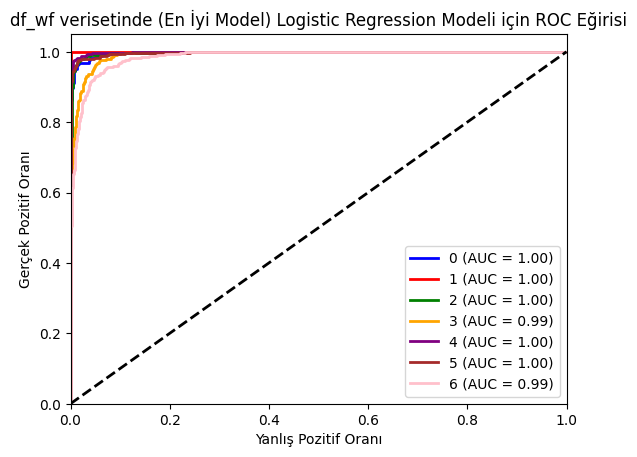

--- Decision Tree ---
DataFrame: df_wf
accuracy: Ortalama = 0.9068, Std = 0.0046
precision: Ortalama = 0.9076, Std = 0.0043
recall: Ortalama = 0.9068, Std = 0.0046
f1: Ortalama = 0.9070, Std = 0.0045


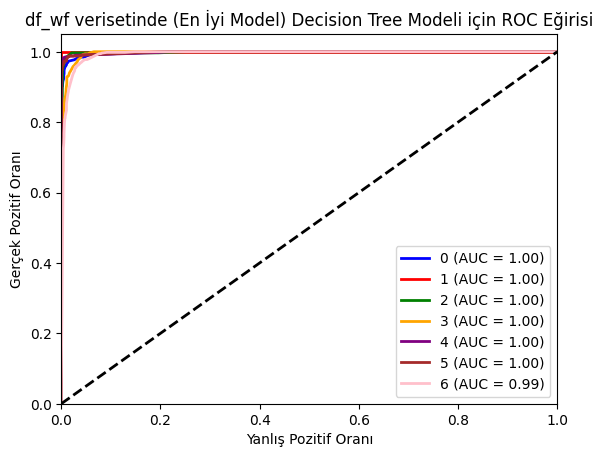

--- Random Forest ---
DataFrame: df_wf
accuracy: Ortalama = 0.9209, Std = 0.0055
precision: Ortalama = 0.9211, Std = 0.0055
recall: Ortalama = 0.9209, Std = 0.0055
f1: Ortalama = 0.9209, Std = 0.0056


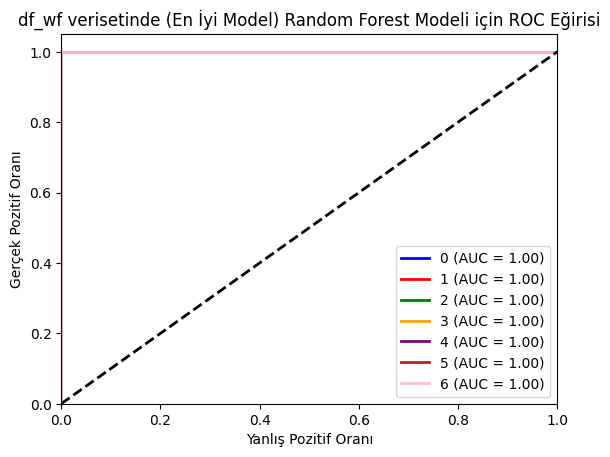

--- XGBoost ---
DataFrame: df_wf
accuracy: Ortalama = 0.9267, Std = 0.0065
precision: Ortalama = 0.9270, Std = 0.0064
recall: Ortalama = 0.9267, Std = 0.0065
f1: Ortalama = 0.9266, Std = 0.0067


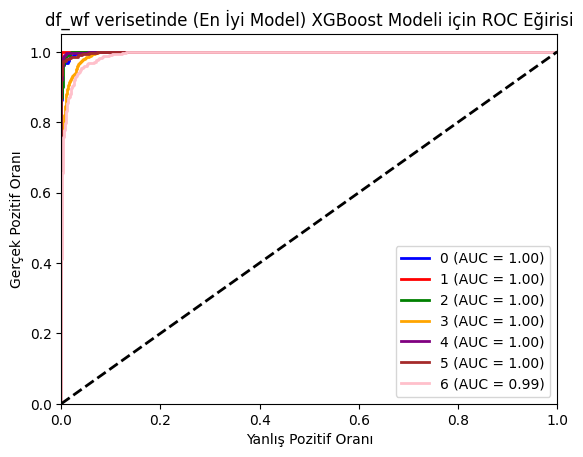

--- Naive Bayes ---
DataFrame: df_wf
accuracy: Ortalama = 0.8967, Std = 0.0036
precision: Ortalama = 0.8985, Std = 0.0042
recall: Ortalama = 0.8967, Std = 0.0036
f1: Ortalama = 0.8969, Std = 0.0038


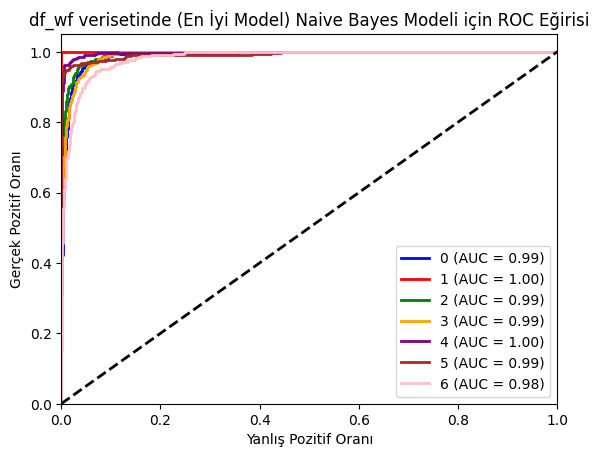

--- Logistic Regression ---
DataFrame: df_pca
accuracy: Ortalama = 0.8712, Std = 0.0044
precision: Ortalama = 0.8716, Std = 0.0054
recall: Ortalama = 0.8712, Std = 0.0044
f1: Ortalama = 0.8704, Std = 0.0044


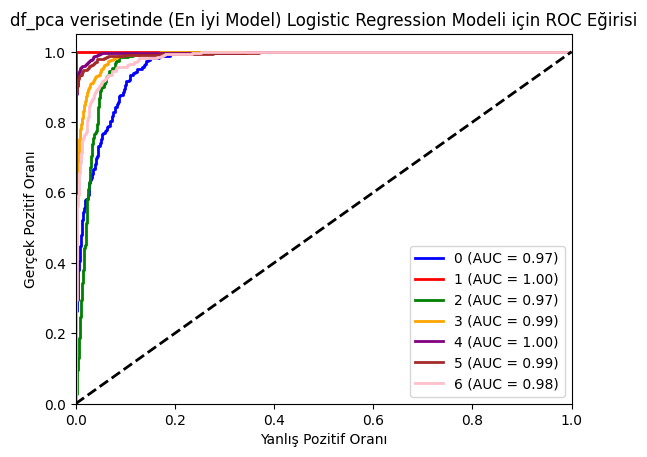

--- Decision Tree ---
DataFrame: df_pca
accuracy: Ortalama = 0.8578, Std = 0.0049
precision: Ortalama = 0.8587, Std = 0.0053
recall: Ortalama = 0.8578, Std = 0.0049
f1: Ortalama = 0.8569, Std = 0.0054


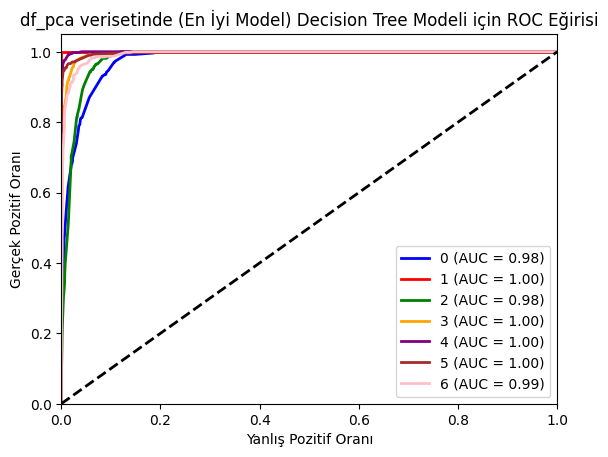

--- Random Forest ---
DataFrame: df_pca
accuracy: Ortalama = 0.8735, Std = 0.0056
precision: Ortalama = 0.8742, Std = 0.0064
recall: Ortalama = 0.8735, Std = 0.0056
f1: Ortalama = 0.8723, Std = 0.0060


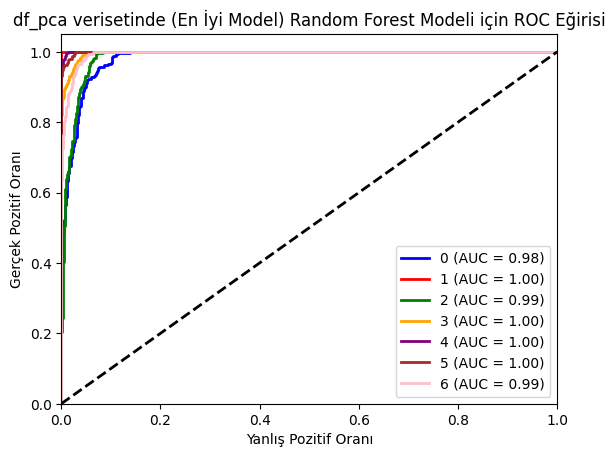

--- XGBoost ---
DataFrame: df_pca
accuracy: Ortalama = 0.8736, Std = 0.0045
precision: Ortalama = 0.8741, Std = 0.0054
recall: Ortalama = 0.8736, Std = 0.0045
f1: Ortalama = 0.8723, Std = 0.0045


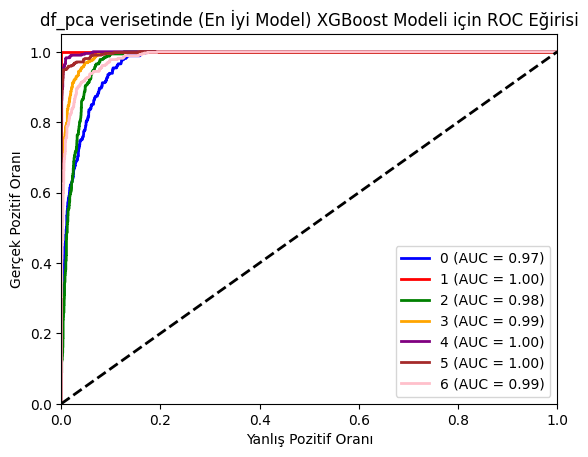

--- Naive Bayes ---
DataFrame: df_pca
accuracy: Ortalama = 0.8644, Std = 0.0044
precision: Ortalama = 0.8664, Std = 0.0059
recall: Ortalama = 0.8644, Std = 0.0044
f1: Ortalama = 0.8627, Std = 0.0043


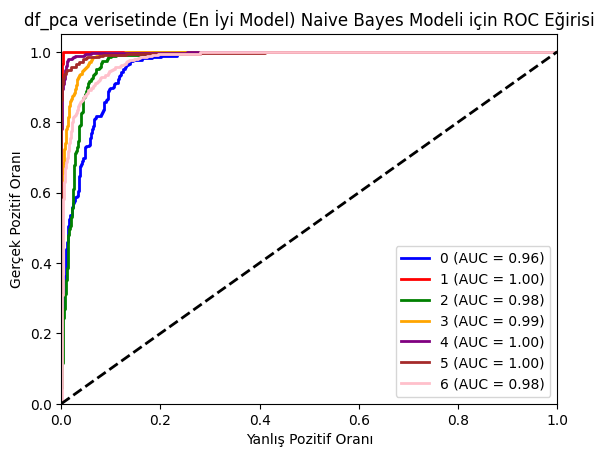

--- Logistic Regression ---
DataFrame: df_lda
accuracy: Ortalama = 0.9037, Std = 0.0041
precision: Ortalama = 0.9043, Std = 0.0046
recall: Ortalama = 0.9037, Std = 0.0041
f1: Ortalama = 0.9037, Std = 0.0044


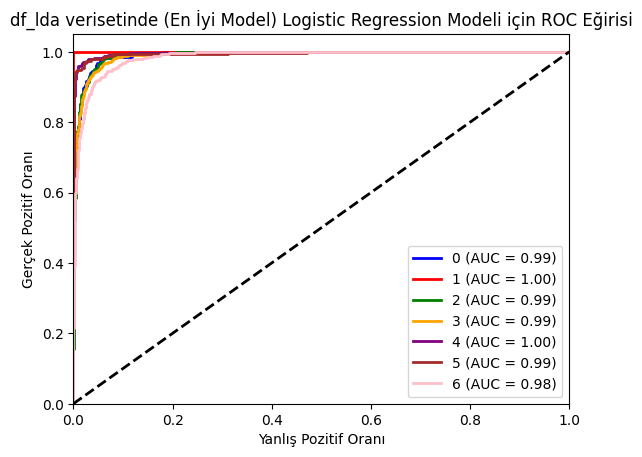

--- Decision Tree ---
DataFrame: df_lda
accuracy: Ortalama = 0.8924, Std = 0.0047
precision: Ortalama = 0.8929, Std = 0.0049
recall: Ortalama = 0.8924, Std = 0.0047
f1: Ortalama = 0.8924, Std = 0.0049


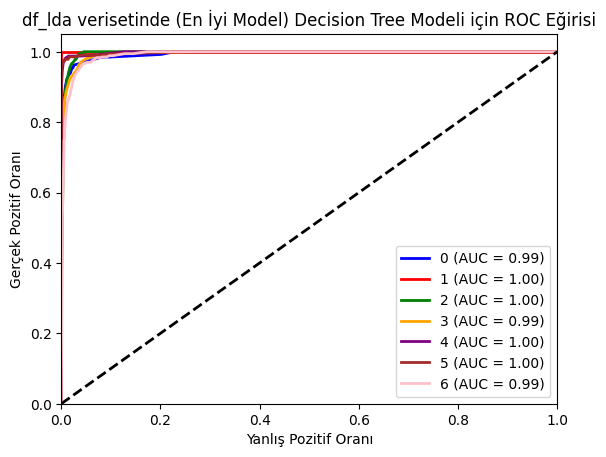

--- Random Forest ---
DataFrame: df_lda
accuracy: Ortalama = 0.9093, Std = 0.0045
precision: Ortalama = 0.9098, Std = 0.0047
recall: Ortalama = 0.9093, Std = 0.0045
f1: Ortalama = 0.9093, Std = 0.0048


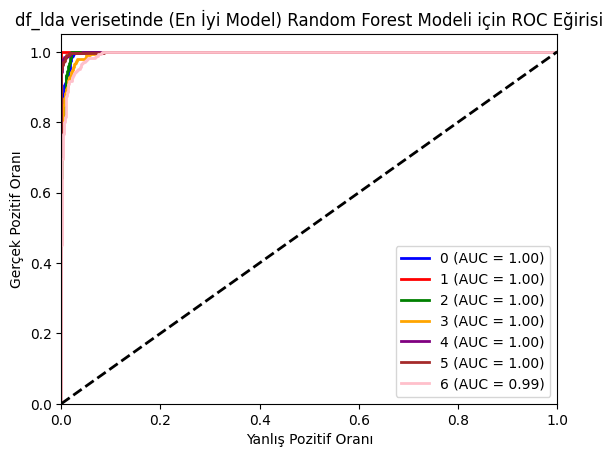

--- XGBoost ---
DataFrame: df_lda
accuracy: Ortalama = 0.9076, Std = 0.0037
precision: Ortalama = 0.9083, Std = 0.0041
recall: Ortalama = 0.9076, Std = 0.0037
f1: Ortalama = 0.9077, Std = 0.0039


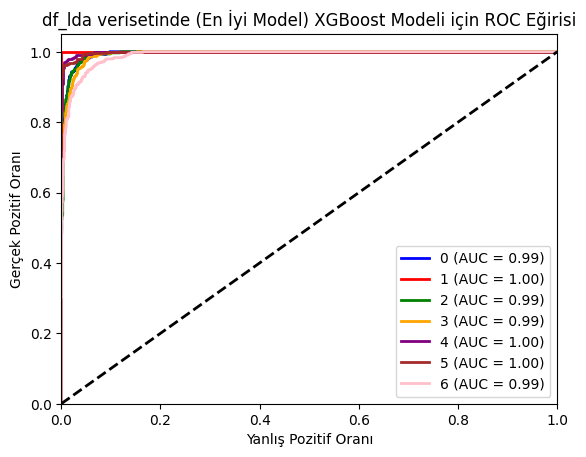

--- Naive Bayes ---
DataFrame: df_lda
accuracy: Ortalama = 0.8949, Std = 0.0050
precision: Ortalama = 0.8961, Std = 0.0059
recall: Ortalama = 0.8949, Std = 0.0050
f1: Ortalama = 0.8949, Std = 0.0052


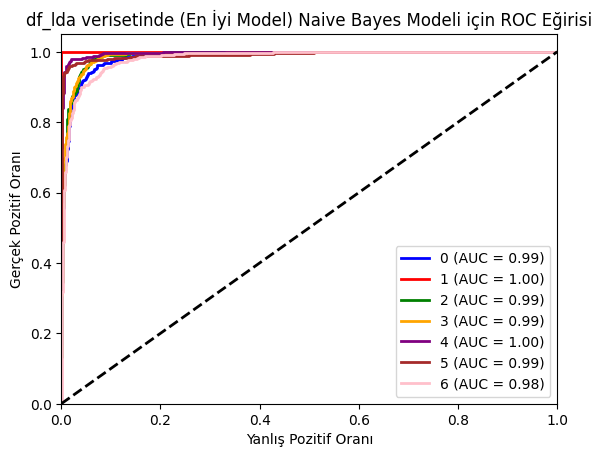

In [ ]:
# Sınıflandırıcıları ve hiperparametre gridlerini tanımlama
siniflandiricilar = {
    'Logistic Regression': (LogisticRegression(random_state=42, max_iter=5000), {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }),
    'Decision Tree': (DecisionTreeClassifier(random_state=42), {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }),
    'Random Forest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20]
    }),
    'XGBoost': (XGBClassifier(random_state=42, eval_metric='logloss'), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 9]
    }),
    'Naive Bayes': (GaussianNB(), {})  # No hyperparameters to tune for Naive Bayes
}

dataframes = {
    'df_wf': df_wf,
    'df_pca': df_pca,
    'df_lda': df_lda
}

def capraz_dogrulama(df, siniflandirici_adi, siniflandirici, parametre_grid):
    X = df.drop('Class', axis=1)
    y = df['Class']
    dis_dogrulama = KFold(n_splits=5, shuffle=True, random_state=42)
    en_iyi_model = None
    en_iyi_auc = 0
    final_sonuclar = []

    # Çapraz Doğrulama Çalıştır
    for train_index, test_index in dis_dogrulama.split(X):
        X_train_outer, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train_outer, y_test = y.iloc[train_index], y.iloc[test_index]

        ic_dogrulama = KFold(n_splits=3, shuffle=True, random_state=42)
        grid_search = GridSearchCV(siniflandirici, parametre_grid, cv=ic_dogrulama, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_outer, y_train_outer)
        mevcut_model = grid_search.best_estimator_

        y_pred = mevcut_model.predict(X_test)
        final_sonuclar.append({
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='weighted'),
            'recall': recall_score(y_test, y_pred, average='weighted'),
            'f1': f1_score(y_test, y_pred, average='weighted')
        })

        # Mevcut model için AUC (Area under curve) hesaplama
        y_score = mevcut_model.predict_proba(X_test)
        y_test_binarized = label_binarize(y_test, classes=np.unique(y))
        sinif_sayisi = y_test_binarized.shape[1]

        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(sinif_sayisi):
            fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
            roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_score[:, i])

        # Modelin daha iyi AUC sonucu varsa onu al
        avg_auc = np.mean(list(roc_auc.values()))
        if avg_auc > en_iyi_auc:
            en_iyi_auc = avg_auc
            en_iyi_model = mevcut_model

    return en_iyi_model, final_sonuclar

# Her sınıflandırıcı ve dataframe için iç içe çapraz doğrulama
for df_tanimi, dfx in dataframes.items():
    for siniflandirici_adi, (siniflandirici, parametre_grid) in siniflandiricilar.items():

        # İç içe çapraz doğrulamadan sonra en iyi modeli bulma
        en_iyi_model, final_sonuclar = capraz_dogrulama(dfx, siniflandirici_adi, siniflandirici, parametre_grid)

        print(f"--- {siniflandirici_adi} ---")
        print(f"DataFrame: {df_tanimi}")
        for metrik in ['accuracy', 'precision', 'recall', 'f1']:
            scores = [result[metrik] for result in final_sonuclar]
            print(f"{metrik}: Ortalama = {np.mean(scores):.4f}, Std = {np.std(scores):.4f}")

        # En iyi model için ROC eğirisi oluşturma
        X = dfx.drop('Class', axis=1)
        y = dfx['Class']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        y_score = en_iyi_model.predict_proba(X_test)  # Get probability scores for ROC curve
        y_test_binarize = label_binarize(y_test, classes=np.unique(y))
        sinif_sayisi = y_test_binarize.shape[1]

        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        # Sayısal indeksler yerine gerçek sınıf adlarını alma
        sinif_isimleri = np.unique(y)

        renk = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])

        for i, renk in zip(range(sinif_sayisi), renk):
            fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
            roc_auc[i] = roc_auc_score(y_test_binarize[:, i], y_score[:, i])

            # Daha iyi anlaşılması için sınıf isimleri kullanılması
            plt.plot(fpr[i], tpr[i], color=renk, lw=2,
                     label=f'{sinif_isimleri[i]} (AUC = {roc_auc[i]:0.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Yanlış Pozitif Oranı')
        plt.ylabel('Gerçek Pozitif Oranı')

        # Daha anlaşılabilir bir başlık tanımı
        plt.title(f'{df_tanimi} verisetinde (En İyi Model) {siniflandirici_adi} Modeli için ROC Eğirisi')
        plt.legend(loc="lower right")
        plt.show()



1. df_wf (Ham Veri Seti):

AUC değerleri genellikle 0.99 ve 1.00 civarında, bu da modellerin yüksek doğrulukla sınıflandırma yaptığına işaret ediyor.

Logistic Regression, Decision Tree, Random Forest, XGBoost gibi modellerin çoğu için AUC değerleri 1.00’a çok yakın. Bu modeller, verilerin doğru şekilde sınıflandırılmasını sağlıyor.

Naive Bayes: AUC değeri biraz daha düşük, özellikle birkaç sınıf için 0.98-0.99 civarına geriliyor. df_wf veri setinde, doğrusal olmayan ilişkilerin model tarafından iyi şekilde öğrenildiği ve çoğu modelin oldukça yüksek doğruluk sergilediği görülüyor. Özellikle XGBoost ve Random Forest, yüksek AUC değerleriyle sınıflandırmalar yapabiliyor. Ancak Naive Bayes gibi daha basit modellerin, çok sınıflı veri setlerinde daha düşük başarı gösterdiği gözlemleniyor.

2. df_pca (PCA ile Dönüştürülmüş Veri Seti):

AUC değerleri yüksek ancak df_wf’e göre daha düşük. Çoğu modelin AUC değeri 0.97 ile 1.00 arasında değişiyor. Özellikle Logistic Regression, Random Forest ve XGBoost iyi performans göstermiş.

Logistic Regression ve Decision Tree için AUC değeri genellikle 0.97-0.99 arasında, bu da veri dönüşümünün modelin doğruluğunu biraz etkilediğini ancak hala iyi performans sergilediğini gösteriyor.

Naive Bayes: Bu model de df_pca üzerinde daha düşük AUC değerleri gösteriyor (0.96-0.98 arası), ancak bu sonuçlar da gayet yeterli görünüyor.  df_pca'daki modeller, genelde df_wf'e göre biraz daha düşük doğruluk sağlamış ama hâlâ yüksek AUC değerleri ile başarılı sınıflandırmalar yapabiliyor.

3. df_lda (LDA ile Dönüştürülmüş Veri Seti):

AUC değerleri, df_pca ve df_wf'e göre daha tutarlı ve genellikle daha yüksek. Çoğu modelin AUC değeri 0.99 ve 1.00 arasında.

Logistic Regression ve Decision Tree için genellikle gayet iyi sonuçlar vermiş. AUC değeri 1.00’a yakın, bu da LDA dönüşümünün lineer ayrılabilirliği iyileştirerek modellerin daha doğru sınıflandırma yapmalarını sağladığını gösteriyor.

Random Forest ve XGBoost modellerinde yüksek AUC değerleri gözlemleniyor. df_lda dönüşümünün bu modellerin doğruluğunu artırmış olması muhtemel.

Naive Bayes: AUC değeri biraz daha düşük (0.98-0.99 civarı), ancak diğer modellere göre yine oldukça iyi performans gösteriyor. LDA dönüşümü, doğrusal ayrılabilirliği artırarak modelin genel doğruluğunu yükseltmiş görünüyor. Bu dönüşümle, özellikle Logistic Regression ve Decision Tree gibi daha basit modellerin daha başarılı sınıflandırmalar yapabildiği ve doğru pozitif oranlarının arttığı gözlemleniyor. Random Forest ve XGBoost gibi daha karmaşık modeller de df_lda dönüşümü ile daha stabil sonuçlar veriyor.

df_wf (Ham Veri Seti): En yüksek AUC değerlerine sahip, modeller çoğunlukla çok başarılı sınıflandırmalar yapabiliyor. Ancak, doğrudan verilerle çalışıldığında, karmaşık ilişkilerden yararlanılabilmesi sınırlı olabilir.

df_pca (PCA Dönüşümü): PCA dönüşümü, bazı doğrusal olmayan ilişkilerin kaybolmasına neden olmuş ve bu da AUC değerlerinde bir düşüşe yol açmış. Ancak yine de yüksek doğruluklar sağlanmış.

df_lda (LDA Dönüşümü): LDA dönüşümü, doğrusal ayrılabilirliği artırarak modelin doğruluğunu büyük ölçüde iyileştirmiş. Özellikle Logistic Regression ve Decision Tree gibi daha basit modellerin performansı arttı. LDA, sınıflar arasındaki farkları daha belirgin hale getirerek yüksek doğruluklar sağlıyor.

df_wf üzerinde model performansı en yüksekken, df_lda dönüşümü sonrası sınıflandırmalar daha doğru hale gelmiş ve en yüksek doğruluklar elde edilmiş.

PCA dönüşümünden sonra, doğrusal ayrılabilirlik azalmakla birlikte, yine de tatmin edici sonuçlar elde edilmiştir.